# Distancia entre textos grandes

En primer lugar vamos a ver un metodo para ver la distancia entre textos grandes, en este caso no tenemos en cuenta la semantica, simplemente la similitud entre palabras. Vamos a descargar 3 libros del mismo autor y ver si conseguimos ver que libros pertenecen a la misma saga y cuales no.

In [152]:
from http.client import responses

import pandas as pd
import requests
import nltk
from nltk.tokenize import regexp_tokenize
import matplotlib.pyplot as plt
import bs4
from bs4 import BeautifulSoup

In [146]:
links_libros = {
    "El Camino de los Reyes": "https://archive.org/stream/el-camino-de-los-reyes-brandon-sanderson_202208/El%20camino%20de%20los%20reyes%20-%20Brandon%20Sanderson_djvu.txt",
    "Palabras Radiantes" : "https://archive.org/stream/palabras-radiantes-brandon-sanderson/Palabras%20radiantes%20-%20Brandon%20Sanderson_djvu.txt",
    "El Imperio Final" : "https://archive.org/stream/el-imperio-final-brandon-sanderson/El%20imperio%20final%20-%20Brandon%20Sanderson_djvu.txt",
}

In [147]:
df_aux = pd.DataFrame(links_libros.items(), columns=["titulo", "url"])

In [148]:
def obtener_texto_de_libro(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text)
    texto_libro = soup.find("pre").text
    return texto_libro

def tokenizar_texto(texto):
    return regexp_tokenize(texto, pattern=r"\w+")

In [149]:
#tokenizar textos del df

df_aux["texto"] = df_aux["url"].apply(obtener_texto_de_libro)
#df_aux["texto"] = df_aux["texto"].apply(lambda x: x[20_000:-2_000])
df_aux["tokens"] = df_aux["texto"].apply(tokenizar_texto)

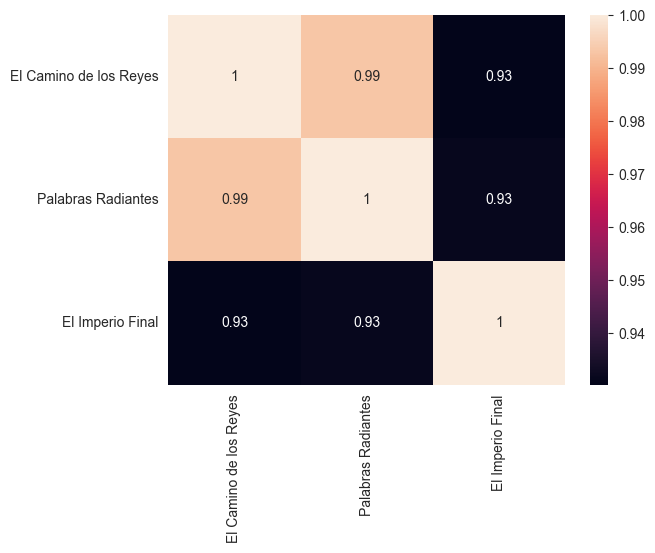

In [173]:
tfidf_vectorizer = TfidfVectorizer()

tfidf_vectores = tfidf_vectorizer.fit_transform(df_aux["texto"])

distancias_tfidf = cosine_similarity(tfidf_vectores)

sns.heatmap(distancias_tfidf, annot=True, xticklabels=df_aux["titulo"], yticklabels=df_aux["titulo"])
plt.show()


Los resultados son exactamente los que queriamos, vemos una mayor similitud entre los libros que pertenecen a la misma saga, y una menor similitud entre los libros que no pertenecen a la misma saga.
Con este metodo conseguimos, ver las distancias entre textos grandes, ya que tienen un vocabulario común y se puede comparar la similitud entre ellos.



# Distancia entre textos pequeños


Para textos pequeños, podemos utilizar un modelo pre-entrenado de BERT, que nos proporciona embeddings de los textos. Con estos embeddings podemos calcular la similitud semántica entre los textos.

In [165]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def obtener_embedding(texto):
    tokens = tokenizer(texto, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**tokens)
    
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

def calcular_similitud(texto1, texto2):
    embedding1 = obtener_embedding(texto1)
    embedding2 = obtener_embedding(texto2)
    
    similitud = cosine_similarity(embedding1, embedding2)
    return similitud[0][0]

La similitud semántica entre los textos es: 0.9220033288002014


In [187]:
texto1 = "El gato está sobre la alfombra."
texto2 = "El felino descansa en la moqueta."
texto3 = "El tren es de color verde"

textos = [texto1, texto2, texto3]

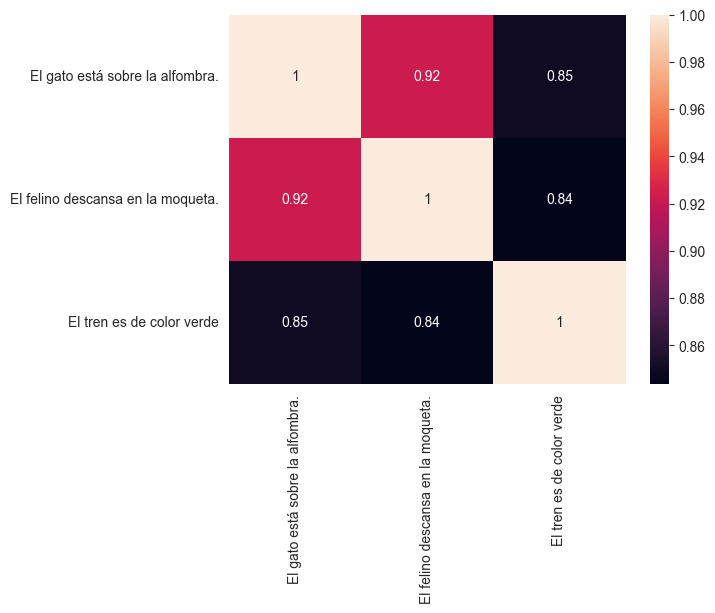

In [188]:
# Calcular la matriz de similitudes
n = len(textos)
matriz_similitud = [[0] * n for _ in range(n)]
for i in range(n):
    for j in range(n):
        matriz_similitud[i][j] = calcular_similitud(textos[i], textos[j])

# Convertir la matriz a un DataFrame de pandas
df_similitud = pd.DataFrame(matriz_similitud, index=textos, columns=textos)

# Plotear el heatmap
sns.heatmap(df_similitud, annot=True, xticklabels=True, yticklabels=True)
plt.show()

De nuevo vemos claramente diferenciados los textos que son semanticamente similares y los que no lo son. Con este metodo podemos ver la similitud entre textos pequeños, ya que BERT tiene un vocabulario muy amplio y puede captar la semantica de las palabras.